<a href="https://colab.research.google.com/github/Gooogr/YOLO_Webcam_Tracker/blob/yolov4_tiny/model_files/Predict_tiny_yolov4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
import urllib.request

import numpy as np
import cv2

from google.colab import files
from google.colab.patches import cv2_imshow

In [3]:
# Enable GPU
# Check what we get: K80, P100, K4 or T4.
! nvidia-smi

Sat Aug 29 14:17:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Utils

In [16]:
def url_to_image(url, save_path=None):
    '''
    Download the image by url-link, convert it to a NumPy array. Encode it into OpenCV format.
    input:
        url - direct url link to image 
    output:
        OpenCV image.
    '''
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")

    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    if save_path is not None:
        cv2.imwrite(save_path, image)
    else:
        return image

## Setting up YOLO Darknet

In [7]:
def make_darknet():
  '''
  Run this function if darknet wasn`t setted up your root project folder
  '''
  # Clone and  make darknet in My Drive folder. We should prepare all config files there befory copy them to tmp
  ! git clone https://github.com/AlexeyAB/darknet.git

  # Enable GPU learning
  %cd darknet
  !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
  !sed -i 's/GPU=0/GPU=1/' Makefile
  !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
  !sed -i 's/OPENMP=0/OPENMP=1/' Makefile

  # verify CUDA
  !/usr/local/cuda/bin/nvcc --version

  ! make --silent

Check saving rules in ```/content/darknet/src/detector.c```, lines 384 - 403

```
 if (iteration >= (iter_save + 1000) || iteration % 1000 == 0) {
     sprintf(buff, "%s/%s_%d.weights", backup_directory, base, iteration);
 if (iteration >= (iter_save_last + 100) || (iteration % 100 == 0 && iteration > 1)) {
     sprintf(buff, "%s/%s_last.weights", backup_directory, base);
```
Change it if you need, but don't forget to ```! make``` it arter that.



In [8]:
%%capture
make_darknet()

### Prepare weights and config files

In [9]:
! mkdir custom_files
% cd ./custom_files

/content/darknet/custom_files


Download weights and .cfg files

In [13]:
! wget --quiet https://raw.githubusercontent.com/Gooogr/YOLO_Webcam_Tracker/yolov4_tiny/model_files/yolov4-tiny-custom.cfg
! wget --quiet  https://github.com/Gooogr/YOLO_Webcam_Tracker/raw/yolov4_tiny/model_files/yolov4-tiny-custom_final.weights

Create obj.names

In [14]:
%%writefile obj.names
Human face
Human hand

Writing obj.names


Create yolo.data file

In [15]:
%%writefile yolo.data
classses = 2
#valid = /content/test.txt
names =  /content/darknet/custom_files/obj.names
#backup = /content/yolo_weights
#train = /content/train.txt

Writing yolo.data


### Predict

In [57]:
# Add here url link to the desired image
crowd_of_people = 'https://upload.wikimedia.org/wikipedia/commons/1/12/Flickr_-_moses_namkung_-_The_Crowd_For_DMB_1.jpg' 
group_of_people = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTpvoS_uA21r_FEhBBiRoBP1TBeu9Llrjdjdg&usqp=CAU'
several_hands = 'https://www.lauramfoley.com/wp-content/uploads/2013/06/show-of-hands.jpg'
indian_crowd = 'https://images.indianexpress.com/2014/03/Migrants-1200-3.jpg'

In [53]:
SCALED_WIDTH = 500

In [54]:
def predict_sample(img_url, scaled_width):
    # Save image
    url_to_image(img_url, save_path='/content/darknet/data/sample_image.jpg')

    # Calculate new image size for result visualization
    img = cv2.imread('/content/darknet/data/sample_image.jpg')
    img_height, img_width, _ =img.shape  
    scale_ratio = scaled_width / img_width
    scaled_height = int(img_height * scale_ratio)

    # YOLO prediction
    % cd /content/darknet
    ! chmod 777 ./darknet
    ! ./darknet detector test custom_files/yolo.data \
     custom_files/yolov4-tiny-custom.cfg \
     custom_files/yolov4-tiny-custom_final.weights \
     data/sample_image.jpg 

    # Show result
    image = cv2.imread('predictions.jpg')
    image = cv2.resize(image, (scaled_width, scaled_height))
    cv2_imshow(image)

/content/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  104 x 104 x 128 
   9 max       

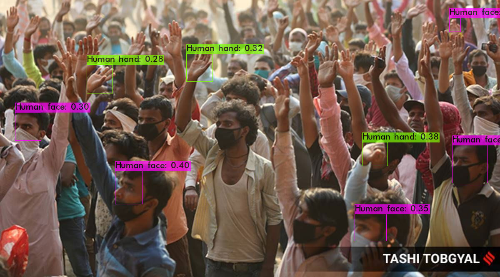

In [58]:
# check that we get working YOLO version
predict_sample(indian_crowd, SCALED_WIDTH)